In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [1]:
import torch
import torch.nn as nn
from torchvision import models

class PaddyHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(PaddyHybridModel, self).__init__()
        # Backbone 1: ResNet18
        self.resnet = models.resnet18(pretrained=True)
        self.resnet_features = nn.Sequential(*list(self.resnet.children())[:-1]) # Remove FC
        
        # Backbone 2: EfficientNet-B0
        self.effnet = models.efficientnet_b0(pretrained=True)
        self.effnet_features = nn.Sequential(*list(self.effnet.children())[:-1]) # Remove classifier
        
        # Combined Classifier
        # ResNet18 output is 512, EffNet-B0 output is 1280
        combined_input_dim = 512 + 1280 
        
        self.classifier = nn.Sequential(
            nn.Linear(combined_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x1 = self.resnet_features(x).view(x.size(0), -1)
        x2 = self.effnet_features(x).view(x.size(0), -1)
        
        # The "Hybrid" Step: Concatenation
        combined = torch.cat((x1, x2), dim=1)
        return self.classifier(combined)

In [2]:
import torch
import torch.nn as nn
from torchvision import models

class PaddyHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(PaddyHybridModel, self).__init__()
        
        # 1. Load ResNet-18 Backbone
        # Use 'pretrained=True' to leverage ImageNet features for early edge detection
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # Extract features by removing the final fully connected layer
        self.resnet_backbone = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # 2. Load EfficientNet-B0 Backbone
        self.effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        # Extract features by removing the classifier head
        self.effnet_backbone = nn.Sequential(*list(self.effnet.children())[:-1])
        
        # 3. Define the Hybrid Head (Fusion Classifier)
        # ResNet18 features: 512 | EfficientNet-B0 features: 1280
        combined_dim = 512 + 1280 
        
        self.fusion_classifier = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4), # Increased dropout to handle high parameter count
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Extract features from both branches
        # x is the input thermal image (B, 3, 224, 224)
        resnet_feat = self.resnet_backbone(x)
        resnet_feat = torch.flatten(resnet_feat, 1) # Shape: (B, 512)
        
        effnet_feat = self.effnet_backbone(x)
        effnet_feat = torch.flatten(effnet_feat, 1) # Shape: (B, 1280)
        
        # Step 4: Feature Fusion (Concatenation)
        combined = torch.cat((resnet_feat, effnet_feat), dim=1)
        
        # Final prediction
        logits = self.fusion_classifier(combined)
        return logits

# Initialize model
# Assuming you have 4 classes: Blast, Hispa, Brown Spot, Healthy
model = PaddyHybridModel(num_classes=4)

In [3]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

In [4]:
import torch
import torch.nn as nn
from torchvision import models

class PaddyHybridModel(nn.Module):
    def __init__(self, num_classes=4):
        super(PaddyHybridModel, self).__init__()
        
        # Backbone 1: ResNet18 (Coarse Features)
        res = models.resnet18(weights='IMAGENET1K_V1')
        self.resnet_feat = nn.Sequential(*list(res.children())[:-1])
        
        # Backbone 2: EfficientNet-B0 (Fine Features)
        eff = models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.effnet_feat = nn.Sequential(*list(eff.children())[:-1])
        
        # Combined Classifier (Late Fusion)
        # ResNet18 (512) + EfficientNet-B0 (1280) = 1792
        self.fusion_classifier = nn.Sequential(
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = torch.flatten(self.resnet_feat(x), 1)
        f2 = torch.flatten(self.effnet_feat(x), 1)
        
        # Concatenate features as seen in your screenshot
        combined = torch.cat((f1, f2), dim=1)
        return self.fusion_classifier(combined)

# Initialization (Matches your second screenshot)
model = PaddyHybridModel(num_classes=4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()

In [6]:
import os
import shutil
import random

# ================= CONFIGURATION =================
# 1. I added your path here based on the screenshot. 
# The 'r' before the quote is important for Windows paths.
SOURCE_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset" 

# 2. Where you want the new structured dataset to be created
DEST_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset"

# 3. Split ratios (Must add up to 1.0)
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15
# =================================================

def split_dataset():
    # Check if source directory exists
    if not os.path.exists(SOURCE_DIR):
        print(f"Error: Could not find folder at: {SOURCE_DIR}")
        print("Please follow the 'How to Copy Path' steps below the code.")
        return

    # Get list of classes (subfolder names)
    # This will pick up: Blast, BLB, healthy, hispa, leaf folder, leaf spot
    classes = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]
    
    if not classes:
        print("No class folders found in source directory.")
        return

    print(f"Found classes: {classes}")

    # Create destination folders
    for split in ['train', 'val', 'test']:
        for class_name in classes:
            os.makedirs(os.path.join(DEST_DIR, split, class_name), exist_ok=True)

    # Process each class
    for class_name in classes:
        class_path = os.path.join(SOURCE_DIR, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Shuffle images to ensure random split
        random.shuffle(images)
        
        total_images = len(images)
        train_count = int(total_images * TRAIN_RATIO)
        val_count = int(total_images * VAL_RATIO)
        
        train_imgs = images[:train_count]
        val_imgs = images[train_count : train_count + val_count]
        test_imgs = images[train_count + val_count:]
        
        print(f"Processing '{class_name}': {total_images} images -> {len(train_imgs)} Train, {len(val_imgs)} Val, {len(test_imgs)} Test")

        # Function to copy files
        def copy_files(file_list, split_type):
            for filename in file_list:
                src = os.path.join(class_path, filename)
                dst = os.path.join(DEST_DIR, split_type, class_name, filename)
                shutil.copy2(src, dst)

        # Execute Copy
        copy_files(train_imgs, 'train')
        copy_files(val_imgs, 'val')
        copy_files(test_imgs, 'test')

    print(f"\nSuccess! New dataset created at: {DEST_DIR}")

if __name__ == "__main__":
    split_dataset()

Found classes: ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']
Processing 'Blast': 67 images -> 46 Train, 10 Val, 11 Test
Processing 'BLB': 220 images -> 154 Train, 33 Val, 33 Test
Processing 'healthy': 93 images -> 65 Train, 13 Val, 15 Test
Processing 'hispa': 142 images -> 99 Train, 21 Val, 22 Test
Processing 'leaf folder': 34 images -> 23 Train, 5 Val, 6 Test
Processing 'leaf spot': 80 images -> 56 Train, 12 Val, 12 Test

Success! New dataset created at: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import time

# ================= CONFIGURATION =================
# 1. Path to your NEW folder containing train/val/test
# Based on your screenshot, it is 'Dataset_2' on your Desktop
DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2"

# 2. Training Settings
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4
# =================================================

def main():
    # ---------------------------------------------------------
    # PART 1: DATA PREPARATION
    # ---------------------------------------------------------
    print("Initializing Data Loaders...")
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                      for x in ['train', 'val']}
    
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True)
                   for x in ['train', 'val']}
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    num_classes = len(class_names)
    
    print(f"Success! Found {num_classes} classes: {class_names}")
    print(f"Training on {dataset_sizes['train']} images, Validating on {dataset_sizes['val']} images.")

    # ---------------------------------------------------------
    # PART 2: HYBRID MODEL DEFINITION
    # ---------------------------------------------------------
    print("\nBuilding Hybrid Model (ResNet18 + EfficientNet-B0)...")
    
    class PaddyHybridModel(nn.Module):
        def __init__(self, num_classes):
            super(PaddyHybridModel, self).__init__()
            # Backbone 1: ResNet18
            res = models.resnet18(weights='IMAGENET1K_V1')
            self.resnet_feat = nn.Sequential(*list(res.children())[:-1])
            
            # Backbone 2: EfficientNet-B0
            eff = models.efficientnet_b0(weights='IMAGENET1K_V1')
            self.effnet_feat = nn.Sequential(*list(eff.children())[:-1])
            
            # Combined Classifier: 512 (ResNet) + 1280 (EffNet) = 1792
            self.fusion_classifier = nn.Sequential(
                nn.Linear(1792, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )

        def forward(self, x):
            f1 = torch.flatten(self.resnet_feat(x), 1)
            f2 = torch.flatten(self.effnet_feat(x), 1)
            combined = torch.cat((f1, f2), dim=1)
            return self.fusion_classifier(combined)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = PaddyHybridModel(num_classes=num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)

    # ---------------------------------------------------------
    # PART 3: TRAINING LOOP
    # ---------------------------------------------------------
    print("\nStarting Training...")
    since = time.time()

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # Save the model
    torch.save(model.state_dict(), 'paddy_hybrid_model.pth')
    print("Model saved as 'paddy_hybrid_model.pth'")

if __name__ == '__main__':
    main()

Initializing Data Loaders...
Success! Found 6 classes: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']
Training on 443 images, Validating on 94 images.

Building Hybrid Model (ResNet18 + EfficientNet-B0)...
Using device: cuda:0

Starting Training...
Epoch 1/15
----------
train Loss: 1.5290 Acc: 0.3860
val Loss: 1.2839 Acc: 0.5745
Epoch 2/15
----------
train Loss: 1.0198 Acc: 0.6569
val Loss: 0.8768 Acc: 0.6809
Epoch 3/15
----------
train Loss: 0.6384 Acc: 0.7968
val Loss: 0.6153 Acc: 0.8191
Epoch 4/15
----------
train Loss: 0.4043 Acc: 0.8939
val Loss: 0.4416 Acc: 0.8830
Epoch 5/15
----------
train Loss: 0.2291 Acc: 0.9661
val Loss: 0.3351 Acc: 0.9149
Epoch 6/15
----------
train Loss: 0.1575 Acc: 0.9729
val Loss: 0.2617 Acc: 0.9149
Epoch 7/15
----------
train Loss: 0.0990 Acc: 0.9707
val Loss: 0.2156 Acc: 0.9255
Epoch 8/15
----------
train Loss: 0.0587 Acc: 0.9887
val Loss: 0.2115 Acc: 0.9362
Epoch 9/15
----------
train Loss: 0.0759 Acc: 0.9752
val Loss: 0.2024 Acc: 0.

Using device: cuda:0
Loading trained model from paddy_hybrid_model.pth...


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_12772\3515220639.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_lo

Running predictions on Test set...

FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

         BLB       0.91      0.97      0.94        33
       Blast       1.00      1.00      1.00        11
     healthy       0.88      0.93      0.90        15
       hispa       1.00      0.95      0.98        22
 leaf folder       1.00      1.00      1.00         6
   leaf spot       1.00      0.83      0.91        12

    accuracy                           0.95        99
   macro avg       0.96      0.95      0.96        99
weighted avg       0.95      0.95      0.95        99



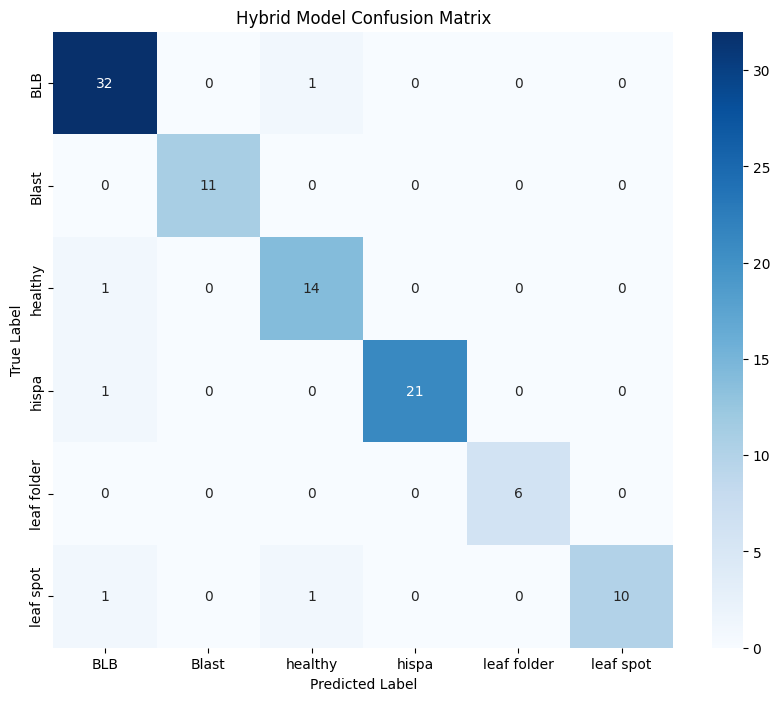

In [8]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import os

# ================= CONFIGURATION =================
# Use the same path as before
DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2"
MODEL_PATH = 'paddy_hybrid_model.pth'
# =================================================

# 1. Re-define the Model Architecture (Must match exactly)
class PaddyHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(PaddyHybridModel, self).__init__()
        # Backbone 1
        res = models.resnet18(weights=None) 
        self.resnet_feat = nn.Sequential(*list(res.children())[:-1])
        # Backbone 2
        eff = models.efficientnet_b0(weights=None)
        self.effnet_feat = nn.Sequential(*list(eff.children())[:-1])
        # Classifier
        self.fusion_classifier = nn.Sequential(
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = torch.flatten(self.resnet_feat(x), 1)
        f2 = torch.flatten(self.effnet_feat(x), 1)
        combined = torch.cat((f1, f2), dim=1)
        return self.fusion_classifier(combined)

def evaluate_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 2. Prepare Test Data
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load 'test' folder
    test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    class_names = test_dataset.classes
    
    print(f"Loading trained model from {MODEL_PATH}...")
    
    # 3. Load Weights
    model = PaddyHybridModel(num_classes=len(class_names))
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()

    # 4. Predictions
    all_preds = []
    all_labels = []

    print("Running predictions on Test set...")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 5. Report & Matrix
    print("\n" + "="*30)
    print("FINAL CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Hybrid Model Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    evaluate_model()

Analyzing image: Thermalimage10a.jpg


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_12772\813935664.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_loc

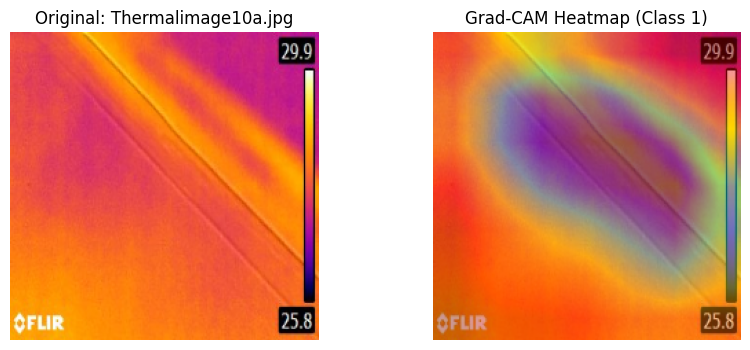

In [11]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob

# ================= CONFIGURATION =================
# 1. We point to the FOLDER, and the code will find the image for you
FOLDER_PATH = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2\test\Blast"
MODEL_PATH = 'paddy_hybrid_model.pth'
# =================================================

# 1. Define Model Architecture (Must match exactly)
class PaddyHybridModel(torch.nn.Module):
    def __init__(self, num_classes=6):
        super(PaddyHybridModel, self).__init__()
        res = models.resnet18(weights=None)
        self.resnet_feat = torch.nn.Sequential(*list(res.children())[:-1])
        eff = models.efficientnet_b0(weights=None)
        self.effnet_feat = torch.nn.Sequential(*list(eff.children())[:-1])
        self.fusion_classifier = torch.nn.Sequential(
            torch.nn.Linear(1792, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = torch.flatten(self.resnet_feat(x), 1)
        f2 = torch.flatten(self.effnet_feat(x), 1)
        combined = torch.cat((f1, f2), dim=1)
        return self.fusion_classifier(combined)

def generate_heatmap():
    # --- AUTO-FIND IMAGE LOGIC ---
    # Find all jpg/png images in the folder
    search_path = os.path.join(FOLDER_PATH, "*.*")
    files = glob.glob(search_path)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"Error: No images found in {FOLDER_PATH}")
        return
        
    # Pick the first one found
    image_path = image_files[0]
    print(f"Analyzing image: {os.path.basename(image_path)}")
    # -----------------------------

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load Model
    model = PaddyHybridModel(num_classes=6)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()

    # Load Image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    raw_img = Image.open(image_path).convert('RGB')
    input_tensor = transform(raw_img).unsqueeze(0).to(device)

    # Hook into ResNet backbone
    target_layer = model.resnet_feat[7]
    
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle_b = target_layer.register_full_backward_hook(backward_hook)
    handle_f = target_layer.register_forward_hook(forward_hook)

    # Forward & Backward
    model.zero_grad()
    output = model(input_tensor)
    pred_idx = output.argmax(dim=1).item()
    output[:, pred_idx].backward()

    # Create Heatmap
    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    # Visualization
    img = cv2.resize(np.array(raw_img), (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original: {os.path.basename(image_path)}")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM Heatmap (Class {pred_idx})")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

    handle_b.remove()
    handle_f.remove()

if __name__ == "__main__":
    try:
        generate_heatmap()
    except Exception as e:
        print(f"Error: {e}")

Searching for images in: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2\test\Blast
Analyzing image: Thermalimage10a.jpg


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_12772\914476252.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_loc

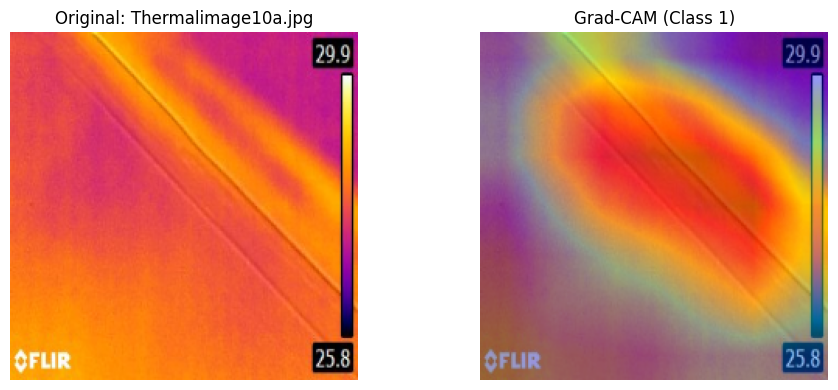

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob

# ================= CONFIGURATION =================
# 1. Path to the folder containing the images you want to test
# The code will automatically pick the first image inside this folder.
FOLDER_PATH = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2\test\Blast"

# 2. Path to your trained model file
MODEL_PATH = 'paddy_hybrid_model.pth'
# =================================================

# -------------------------------------------------
# 1. Define Model Architecture 
# (Must match your training script exactly)
# -------------------------------------------------
class PaddyHybridModel(nn.Module):
    def __init__(self, num_classes=6):
        super(PaddyHybridModel, self).__init__()
        
        # Backbone 1: ResNet18
        res = models.resnet18(weights=None)
        self.resnet_feat = nn.Sequential(*list(res.children())[:-1])
        
        # Backbone 2: EfficientNet-B0
        eff = models.efficientnet_b0(weights=None)
        self.effnet_feat = nn.Sequential(*list(eff.children())[:-1])
        
        # Fusion Classifier
        self.fusion_classifier = nn.Sequential(
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = torch.flatten(self.resnet_feat(x), 1)
        f2 = torch.flatten(self.effnet_feat(x), 1)
        combined = torch.cat((f1, f2), dim=1)
        return self.fusion_classifier(combined)

# -------------------------------------------------
# 2. Grad-CAM Logic
# -------------------------------------------------
def generate_heatmap_fixed():
    # --- Step A: Find an Image ---
    print(f"Searching for images in: {FOLDER_PATH}")
    search_path = os.path.join(FOLDER_PATH, "*.*")
    files = glob.glob(search_path)
    # Filter for valid image formats
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"Error: No images found in {FOLDER_PATH}")
        print("Check if the path is correct and contains .jpg or .png files.")
        return
        
    image_path = image_files[0]
    print(f"Analyzing image: {os.path.basename(image_path)}")

    # --- Step B: Load Model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PaddyHybridModel(num_classes=6)
    
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    except FileNotFoundError:
        print(f"Error: Could not find model file '{MODEL_PATH}'")
        return
        
    model.to(device)
    model.eval()

    # --- Step C: Preprocess Image ---
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    raw_img = Image.open(image_path).convert('RGB')
    input_tensor = transform(raw_img).unsqueeze(0).to(device)

    # --- Step D: Register Hooks ---
    # We hook into the last convolutional layer of ResNet backbone (layer index 7)
    target_layer = model.resnet_feat[7]
    
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle_b = target_layer.register_full_backward_hook(backward_hook)
    handle_f = target_layer.register_forward_hook(forward_hook)

    # --- Step E: Forward & Backward Pass ---
    model.zero_grad()
    output = model(input_tensor)
    pred_idx = output.argmax(dim=1).item()
    
    # Backpropagate specifically for the predicted class
    output[:, pred_idx].backward()

    # --- Step F: Generate Heatmap ---
    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]
    
    # Global Average Pooling of gradients
    weights = np.mean(grads, axis=(1, 2))
    
    # Weighted sum of feature maps
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]

    # ReLU (Remove negative values)
    cam = np.maximum(cam, 0)
    
    # Resize to image size
    cam = cv2.resize(cam, (224, 224))
    
    # Normalize between 0 and 1
    cam = cam - np.min(cam)
    if np.max(cam) != 0:
        cam = cam / np.max(cam)

    # --- Step G: Color Fix & Superimpose ---
    # Convert grayscale CAM to heatmap (BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    
    # FIX: Convert BGR to RGB so Matplotlib displays Red as Red
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Resize original image to match
    img_rgb = np.array(raw_img)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    
    # Blend images (0.6 Original + 0.4 Heatmap)
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    # --- Step H: Plot Results ---
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.title(f"Original: {os.path.basename(image_path)}")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM (Class {pred_idx})")
    plt.imshow(superimposed_img)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Cleanup hooks
    handle_b.remove()
    handle_f.remove()

if __name__ == "__main__":
    generate_heatmap_fixed()

Searching for images in: C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2\test\Blast
Analyzing image: Thermalimage10a.jpg


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_12772\914476252.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_loc

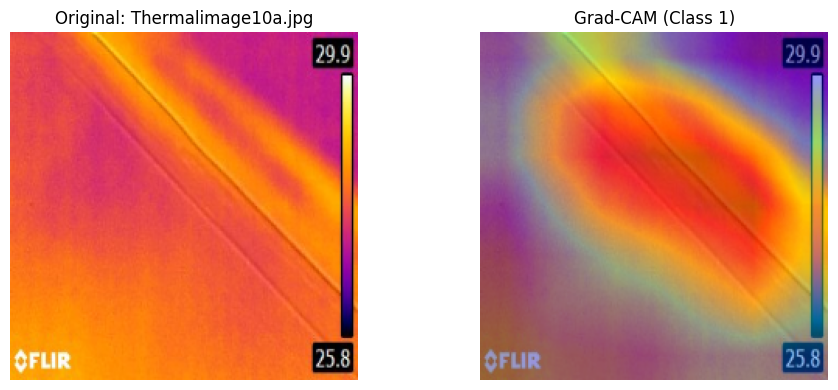

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob

# ================= CONFIGURATION =================
# 1. Path to the folder containing the images you want to test
# The code will automatically pick the first image inside this folder.
FOLDER_PATH = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2\test\Blast"

# 2. Path to your trained model file
MODEL_PATH = 'paddy_hybrid_model.pth'
# =================================================

# -------------------------------------------------
# 1. Define Model Architecture 
# (Must match your training script exactly)
# -------------------------------------------------
class PaddyHybridModel(nn.Module):
    def __init__(self, num_classes=6):
        super(PaddyHybridModel, self).__init__()
        
        # Backbone 1: ResNet18
        res = models.resnet18(weights=None)
        self.resnet_feat = nn.Sequential(*list(res.children())[:-1])
        
        # Backbone 2: EfficientNet-B0
        eff = models.efficientnet_b0(weights=None)
        self.effnet_feat = nn.Sequential(*list(eff.children())[:-1])
        
        # Fusion Classifier
        self.fusion_classifier = nn.Sequential(
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = torch.flatten(self.resnet_feat(x), 1)
        f2 = torch.flatten(self.effnet_feat(x), 1)
        combined = torch.cat((f1, f2), dim=1)
        return self.fusion_classifier(combined)

# -------------------------------------------------
# 2. Grad-CAM Logic
# -------------------------------------------------
def generate_heatmap_fixed():
    # --- Step A: Find an Image ---
    print(f"Searching for images in: {FOLDER_PATH}")
    search_path = os.path.join(FOLDER_PATH, "*.*")
    files = glob.glob(search_path)
    # Filter for valid image formats
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"Error: No images found in {FOLDER_PATH}")
        print("Check if the path is correct and contains .jpg or .png files.")
        return
        
    image_path = image_files[0]
    print(f"Analyzing image: {os.path.basename(image_path)}")

    # --- Step B: Load Model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PaddyHybridModel(num_classes=6)
    
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    except FileNotFoundError:
        print(f"Error: Could not find model file '{MODEL_PATH}'")
        return
        
    model.to(device)
    model.eval()

    # --- Step C: Preprocess Image ---
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    raw_img = Image.open(image_path).convert('RGB')
    input_tensor = transform(raw_img).unsqueeze(0).to(device)

    # --- Step D: Register Hooks ---
    # We hook into the last convolutional layer of ResNet backbone (layer index 7)
    target_layer = model.resnet_feat[7]
    
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle_b = target_layer.register_full_backward_hook(backward_hook)
    handle_f = target_layer.register_forward_hook(forward_hook)

    # --- Step E: Forward & Backward Pass ---
    model.zero_grad()
    output = model(input_tensor)
    pred_idx = output.argmax(dim=1).item()
    
    # Backpropagate specifically for the predicted class
    output[:, pred_idx].backward()

    # --- Step F: Generate Heatmap ---
    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]
    
    # Global Average Pooling of gradients
    weights = np.mean(grads, axis=(1, 2))
    
    # Weighted sum of feature maps
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]

    # ReLU (Remove negative values)
    cam = np.maximum(cam, 0)
    
    # Resize to image size
    cam = cv2.resize(cam, (224, 224))
    
    # Normalize between 0 and 1
    cam = cam - np.min(cam)
    if np.max(cam) != 0:
        cam = cam / np.max(cam)

    # --- Step G: Color Fix & Superimpose ---
    # Convert grayscale CAM to heatmap (BGR)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    
    # FIX: Convert BGR to RGB so Matplotlib displays Red as Red
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Resize original image to match
    img_rgb = np.array(raw_img)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    
    # Blend images (0.6 Original + 0.4 Heatmap)
    superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    # --- Step H: Plot Results ---
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.title(f"Original: {os.path.basename(image_path)}")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM (Class {pred_idx})")
    plt.imshow(superimposed_img)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Cleanup hooks
    handle_b.remove()
    handle_f.remove()

if __name__ == "__main__":
    generate_heatmap_fixed()

Running on: cuda
Classes Detected: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_22048\3393366976.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_l


1. Calculating Metrics (This may take a moment)...

CLASSIFICATION REPORT (F1-Score)
              precision    recall  f1-score   support

         BLB       0.91      0.97      0.94        33
       Blast       1.00      1.00      1.00        11
     healthy       0.88      0.93      0.90        15
       hispa       1.00      0.95      0.98        22
 leaf folder       1.00      1.00      1.00         6
   leaf spot       1.00      0.83      0.91        12

    accuracy                           0.95        99
   macro avg       0.96      0.95      0.96        99
weighted avg       0.95      0.95      0.95        99



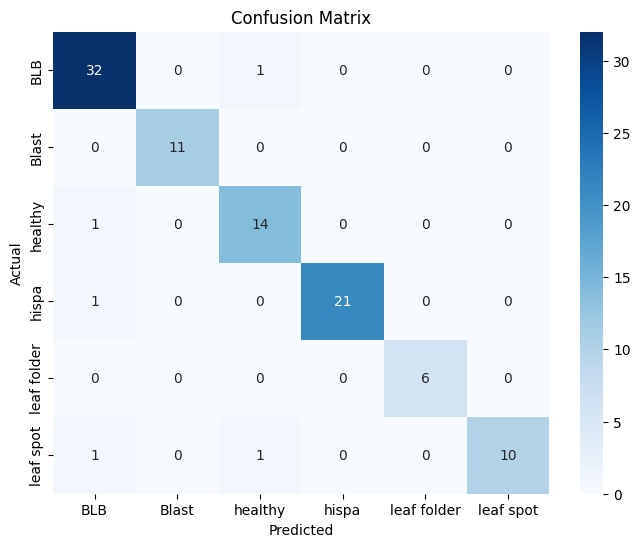


2. Generating Heatmap & Treatment Plan...


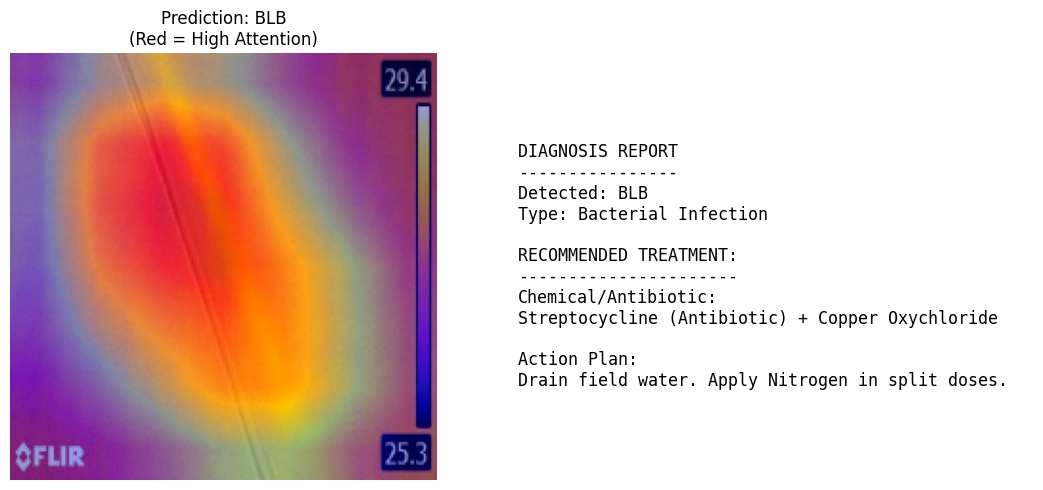

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import glob

# ================= USER CONFIGURATION =================
# 1. Path to your Test Folder
DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2"

# 2. Path to the SPECIFIC image you want to test & visualize
# (Leave as None to auto-pick the first 'Blast' image)
TEST_IMAGE_PATH = None 
# TEST_IMAGE_PATH = r"C:\path\to\specific\image.jpg"

# 3. Path to your trained model
MODEL_PATH = 'paddy_hybrid_model.pth'
# ======================================================

# --- PART 1: TREATMENT DATABASE ---
# Agricultural recommendations for each class
TREATMENTS = {
    'Blast': {
        'Type': 'Fungal Infection',
        'Antibiotic/Chemical': 'Tricyclazole 75% WP or Isoprothiolane 40% EC',
        'Action': 'Spray at early leaf stage. Maintain water level.'
    },
    'BLB': { # Bacterial Leaf Blight
        'Type': 'Bacterial Infection',
        'Antibiotic/Chemical': 'Streptocycline (Antibiotic) + Copper Oxychloride',
        'Action': 'Drain field water. Apply Nitrogen in split doses.'
    },
    'Brown_Spot': {
        'Type': 'Fungal Infection',
        'Antibiotic/Chemical': 'Mancozeb 75% WP or Carbendazim 50% WP',
        'Action': 'Improve soil fertility (add Potash/Zinc).'
    },
    'Hispa': {
        'Type': 'Insect Pest',
        'Antibiotic/Chemical': 'Chlorpyriphos 20% EC or Quinalphos 25% EC',
        'Action': 'Clip leaf tips before transplanting. Use light traps.'
    },
    'Leaf_Folder': {
        'Type': 'Insect Pest',
        'Antibiotic/Chemical': 'Cartap Hydrochloride 50% SP',
        'Action': 'Release Trichogramma parasites. Avoid excessive Urea.'
    },
    'Healthy': {
        'Type': 'Healthy',
        'Antibiotic/Chemical': 'None',
        'Action': 'Continue standard irrigation and monitoring.'
    },
    # Fallback for folder naming variations
    'healthy': {'Type': 'Healthy', 'Antibiotic/Chemical': 'None', 'Action': 'Monitor.'},
    'leaf folder': {'Type': 'Insect', 'Antibiotic/Chemical': 'Cartap Hydrochloride', 'Action': 'Spray.'},
    'leaf spot': {'Type': 'Fungal', 'Antibiotic/Chemical': 'Mancozeb', 'Action': 'Spray.'},
    'hispa': {'Type': 'Insect', 'Antibiotic/Chemical': 'Chlorpyriphos', 'Action': 'Spray.'}
}

# --- PART 2: MODEL DEFINITION ---
class PaddyHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(PaddyHybridModel, self).__init__()
        res = models.resnet18(weights=None)
        self.resnet_feat = nn.Sequential(*list(res.children())[:-1])
        eff = models.efficientnet_b0(weights=None)
        self.effnet_feat = nn.Sequential(*list(eff.children())[:-1])
        self.fusion_classifier = nn.Sequential(
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = torch.flatten(self.resnet_feat(x), 1)
        f2 = torch.flatten(self.effnet_feat(x), 1)
        return self.fusion_classifier(torch.cat((f1, f2), dim=1))

# --- PART 3: EVALUATION & VISUALIZATION ---
def run_full_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on: {device}")

    # A. Setup Data
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    test_dir = os.path.join(DATA_DIR, 'test')
    test_dataset = datasets.ImageFolder(test_dir, transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    class_names = test_dataset.classes
    print(f"Classes Detected: {class_names}")

    # B. Load Model
    model = PaddyHybridModel(num_classes=len(class_names))
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()

    # C. Calculate Metrics (F1 & Confusion Matrix)
    print("\n1. Calculating Metrics (This may take a moment)...")
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print Report
    print("\n" + "="*40)
    print("CLASSIFICATION REPORT (F1-Score)")
    print("="*40)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # D. Run Grad-CAM + Treatment on Single Image
    print("\n2. Generating Heatmap & Treatment Plan...")
    
    # Auto-pick image if none provided
    target_img_path = TEST_IMAGE_PATH
    if target_img_path is None:
        # Default to finding a 'Blast' image
        search_path = os.path.join(test_dir, class_names[0], "*.*") 
        files = glob.glob(search_path)
        if files: target_img_path = files[0]
        else: print("Error: No images found to visualize."); return

    # Load and Preprocess single image
    raw_img = Image.open(target_img_path).convert('RGB')
    img_tensor = transform(raw_img).unsqueeze(0).to(device)

    # Hooks for Grad-CAM
    target_layer = model.resnet_feat[7]
    gradients, activations = [], []

    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    def forward_hook(module, input, output): activations.append(output)

    handle_b = target_layer.register_full_backward_hook(backward_hook)
    handle_f = target_layer.register_forward_hook(forward_hook)

    # Prediction
    model.zero_grad()
    output = model(img_tensor)
    pred_idx = output.argmax(dim=1).item()
    pred_class = class_names[pred_idx]
    
    # Backward pass for Heatmap
    output[:, pred_idx].backward()
    
    # Generate Heatmap
    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights): cam += w * fmap[i, :, :]
    
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - np.min(cam)) / (np.max(cam) + 1e-8)
    
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    img_rgb = cv2.resize(np.array(raw_img), (224, 224))
    superimposed = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    # Clean hooks
    handle_b.remove(); handle_f.remove()

    # E. Display Final Output
    treatment = TREATMENTS.get(pred_class, TREATMENTS.get(pred_class.lower(), {'Antibiotic/Chemical': 'Consult Expert'}))

    plt.figure(figsize=(12, 5))
    
    # Subplot 1: Image + Heatmap
    plt.subplot(1, 2, 1)
    plt.imshow(superimposed)
    plt.title(f"Prediction: {pred_class}\n(Red = High Attention)")
    plt.axis('off')
    
    # Subplot 2: Treatment Text
    plt.subplot(1, 2, 2)
    plt.axis('off')
    text_str = (
        f"DIAGNOSIS REPORT\n"
        f"----------------\n"
        f"Detected: {pred_class}\n"
        f"Type: {treatment.get('Type', 'N/A')}\n\n"
        f"RECOMMENDED TREATMENT:\n"
        f"----------------------\n"
        f"Chemical/Antibiotic:\n{treatment['Antibiotic/Chemical']}\n\n"
        f"Action Plan:\n{treatment['Action']}"
    )
    plt.text(0.05, 0.5, text_str, fontsize=12, va='center', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_full_analysis()

Running analysis on: cuda
Classes Detected: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


C:\Users\jeevabharathi\AppData\Local\Temp\ipykernel_22048\3976767728.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_l

Model loaded successfully.

[1/3] Calculating Performance Metrics...

FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

         BLB       0.91      0.97      0.94        33
       Blast       1.00      1.00      1.00        11
     healthy       0.88      0.93      0.90        15
       hispa       1.00      0.95      0.98        22
 leaf folder       1.00      1.00      1.00         6
   leaf spot       1.00      0.83      0.91        12

    accuracy                           0.95        99
   macro avg       0.96      0.95      0.96        99
weighted avg       0.95      0.95      0.95        99



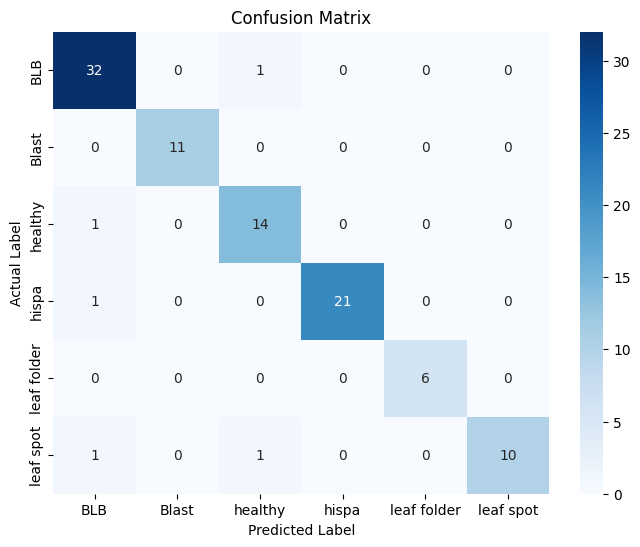


[2/3] Generating Diagnosis & Treatment Plan...
Analyzing: Thermalimage10a.jpg


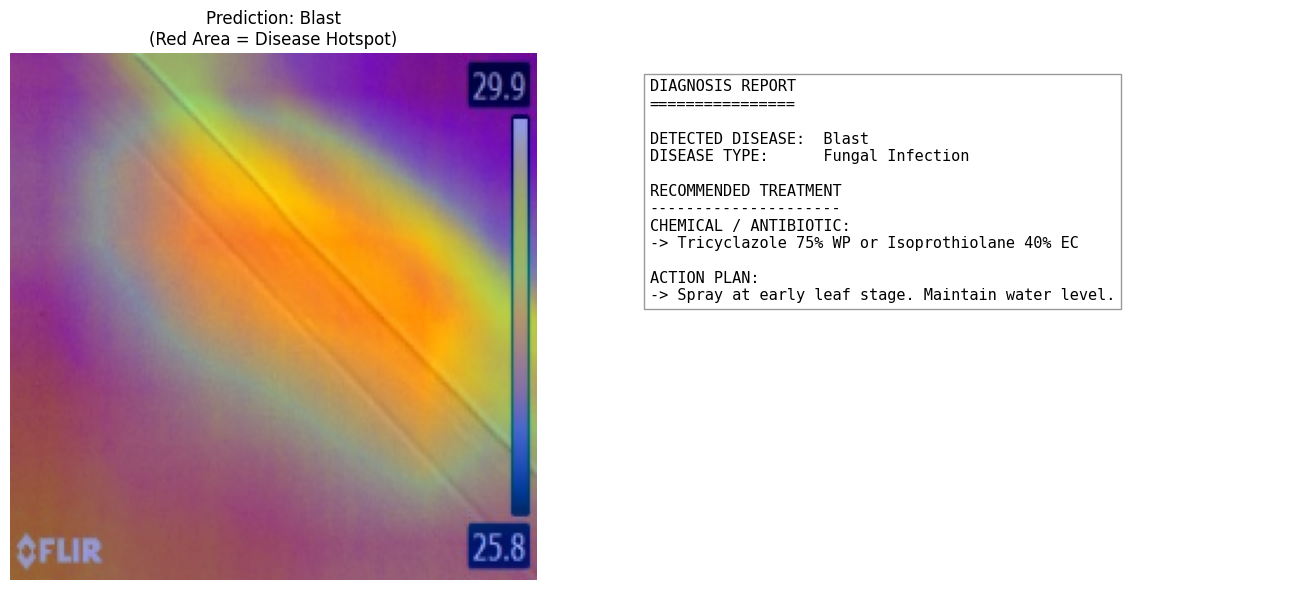

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import glob

# ================= USER CONFIGURATION =================
# 1. Path to your Dataset Folder
DATA_DIR = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2"

# 2. Path to your trained model
MODEL_PATH = 'paddy_hybrid_model.pth'

# 3. Specific image to test? (Set to None to auto-pick a random 'Blast' image)
TEST_IMAGE_PATH = None 
# Example: TEST_IMAGE_PATH = r"C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_2\test\Blast\image_01.jpg"
# ======================================================

# --- PART 1: TREATMENT DATABASE ---
# Recommendations for Paddy Crop Diseases
TREATMENTS = {
    'Blast': {
        'Type': 'Fungal Infection',
        'Antibiotic/Chemical': 'Tricyclazole 75% WP or Isoprothiolane 40% EC',
        'Action': 'Spray at early leaf stage. Maintain water level.'
    },
    'BLB': { # Bacterial Leaf Blight
        'Type': 'Bacterial Infection',
        'Antibiotic/Chemical': 'Streptocycline (Antibiotic) + Copper Oxychloride',
        'Action': 'Drain field water. Apply Nitrogen in split doses.'
    },
    'Brown_Spot': {
        'Type': 'Fungal Infection',
        'Antibiotic/Chemical': 'Mancozeb 75% WP or Carbendazim 50% WP',
        'Action': 'Improve soil fertility (add Potash/Zinc).'
    },
    'Hispa': {
        'Type': 'Insect Pest',
        'Antibiotic/Chemical': 'Chlorpyriphos 20% EC or Quinalphos 25% EC',
        'Action': 'Clip leaf tips before transplanting. Use light traps.'
    },
    'Leaf_Folder': {
        'Type': 'Insect Pest',
        'Antibiotic/Chemical': 'Cartap Hydrochloride 50% SP',
        'Action': 'Release Trichogramma parasites. Avoid excessive Urea.'
    },
    'Leaf_Spot': {
        'Type': 'Fungal Infection',
        'Antibiotic/Chemical': 'Propiconazole 25% EC',
        'Action': 'Spray during early infection signs.'
    },
    'Healthy': {
        'Type': 'Healthy',
        'Antibiotic/Chemical': 'None',
        'Action': 'Continue standard irrigation and monitoring.'
    }
}

# --- PART 2: MODEL DEFINITION ---
# Must match the architecture used to train 'paddy_hybrid_model.pth'
class PaddyHybridModel(nn.Module):
    def __init__(self, num_classes):
        super(PaddyHybridModel, self).__init__()
        # Backbone 1: ResNet18
        res = models.resnet18(weights=None)
        self.resnet_feat = nn.Sequential(*list(res.children())[:-1])
        
        # Backbone 2: EfficientNet-B0
        eff = models.efficientnet_b0(weights=None)
        self.effnet_feat = nn.Sequential(*list(eff.children())[:-1])
        
        # Fusion Classifier
        self.fusion_classifier = nn.Sequential(
            nn.Linear(1792, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        f1 = torch.flatten(self.resnet_feat(x), 1)
        f2 = torch.flatten(self.effnet_feat(x), 1)
        return self.fusion_classifier(torch.cat((f1, f2), dim=1))

# --- PART 3: MAIN EXECUTION ---
def run_full_analysis():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running analysis on: {device}")

    # A. Setup Data & Transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Load Test Data
    test_dir = os.path.join(DATA_DIR, 'test')
    if not os.path.exists(test_dir):
        print(f"Error: Could not find test folder at {test_dir}")
        return

    test_dataset = datasets.ImageFolder(test_dir, transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    class_names = test_dataset.classes
    print(f"Classes Detected: {class_names}")

    # B. Load Model
    model = PaddyHybridModel(num_classes=len(class_names))
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print("Model loaded successfully.")
    except FileNotFoundError:
        print(f"Error: Model file '{MODEL_PATH}' not found.")
        return

    model.to(device)
    model.eval()

    # C. METRICS: F1-Score & Confusion Matrix
    print("\n[1/3] Calculating Performance Metrics...")
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print Classification Report
    print("\n" + "="*50)
    print("FINAL CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # D. VISUALIZATION: Grad-CAM & Treatments
    print("\n[2/3] Generating Diagnosis & Treatment Plan...")
    
    # Auto-pick an image if none provided
    target_img_path = TEST_IMAGE_PATH
    if target_img_path is None:
        # Try to find a 'Blast' or 'Hispa' image to show something interesting
        for disease in ['Blast', 'Hispa', 'BLB', class_names[0]]:
            search_path = os.path.join(test_dir, disease, "*.*")
            files = glob.glob(search_path)
            valid_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if valid_files:
                target_img_path = valid_files[0]
                break
    
    if not target_img_path:
        print("Error: No images found to visualize.")
        return

    print(f"Analyzing: {os.path.basename(target_img_path)}")

    # Load Single Image
    raw_img = Image.open(target_img_path).convert('RGB')
    img_tensor = transform(raw_img).unsqueeze(0).to(device)

    # Hook into ResNet for Grad-CAM
    target_layer = model.resnet_feat[7] # Last ResNet conv block
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    def forward_hook(module, input, output):
        activations.append(output)

    handle_b = target_layer.register_full_backward_hook(backward_hook)
    handle_f = target_layer.register_forward_hook(forward_hook)

    # Forward & Backward Pass
    model.zero_grad()
    output = model(img_tensor)
    pred_idx = output.argmax(dim=1).item()
    pred_class = class_names[pred_idx]
    
    # Backpropagate for the predicted class
    output[:, pred_idx].backward()
    
    # Generate Heatmap
    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]
    
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - np.min(cam)) / (np.max(cam) + 1e-8)
    
    # Color Map (Blue-Red)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # Fix colors
    
    # Superimpose
    img_rgb = cv2.resize(np.array(raw_img), (224, 224))
    superimposed = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    # Cleanup Hooks
    handle_b.remove()
    handle_f.remove()

    # E. DISPLAY RESULT
    # Normalize class name for dictionary lookup (handle case variations)
    lookup_key = None
    for key in TREATMENTS.keys():
        if key.lower() == pred_class.lower().replace(" ", "_"):
            lookup_key = key
            break
        if key.lower() == pred_class.lower(): # Direct match
            lookup_key = key
            break
            
    # Default fallback
    if lookup_key:
        treatment = TREATMENTS[lookup_key]
    else:
        treatment = {'Type': 'Unknown', 'Antibiotic/Chemical': 'Consult Expert', 'Action': 'N/A'}

    plt.figure(figsize=(14, 6))
    
    # Left: The Image
    plt.subplot(1, 2, 1)
    plt.imshow(superimposed)
    plt.title(f"Prediction: {pred_class}\n(Red Area = Disease Hotspot)")
    plt.axis('off')
    
    # Right: The Report
    plt.subplot(1, 2, 2)
    plt.axis('off')
    
    report_text = (
        f"DIAGNOSIS REPORT\n"
        f"================\n\n"
        f"DETECTED DISEASE:  {pred_class}\n"
        f"DISEASE TYPE:      {treatment.get('Type', 'N/A')}\n\n"
        f"RECOMMENDED TREATMENT\n"
        f"---------------------\n"
        f"CHEMICAL / ANTIBIOTIC:\n"
        f"-> {treatment['Antibiotic/Chemical']}\n\n"
        f"ACTION PLAN:\n"
        f"-> {treatment['Action']}"
    )
    
    plt.text(0.05, 0.95, report_text, fontsize=11, va='top', fontfamily='monospace', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_full_analysis()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import os
from sklearn.metrics import classification_report

# --- STEP 1: SETUP DATA LOADING (Fixes 'train_loader' error) ---
# Check your path again to be sure!
data_dir = r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_Split_EfficientNet'
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Loading Data...")
try:
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    train_loader = DataLoader(image_datasets['train'], batch_size=32, shuffle=True)
    val_loader = DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
    class_names = image_datasets['train'].classes
    print(f"Data loaded successfully! Classes: {class_names}")
except Exception as e:
    print(f"Error loading data: {e}")

# --- STEP 2: DEFINE RESNET MODEL ---
print("\n--- EXPERIMENT 1: Training ResNet-18 (Alone) ---")
model_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes) 
model_resnet = model_resnet.to(device)

optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

# --- STEP 3: TRAIN (Passing 'train_loader' explicitly) ---
def train_baseline(model, optimizer, loader, epochs=8):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in loader:  # Uses the 'loader' passed to the function
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} done. Loss: {running_loss/len(loader):.3f}")

# Run Training
train_baseline(model_resnet, optimizer_resnet, train_loader, epochs=8)

# --- STEP 4: EVALUATE ---
print("\nResults for ResNet-18 Only:")
y_true, y_pred = [], []
model_resnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model_resnet(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Loading Data...
Data loaded successfully! Classes: ['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']

--- EXPERIMENT 1: Training ResNet-18 (Alone) ---
Epoch 1/8 done. Loss: 1.084
Epoch 2/8 done. Loss: 0.453
Epoch 3/8 done. Loss: 0.283
Epoch 4/8 done. Loss: 0.204
Epoch 5/8 done. Loss: 0.151
Epoch 6/8 done. Loss: 0.149
Epoch 7/8 done. Loss: 0.092
Epoch 8/8 done. Loss: 0.076

Results for ResNet-18 Only:
              precision    recall  f1-score   support

         BLB     0.9512    0.8864    0.9176        44
       Blast     0.5455    0.8571    0.6667        14
     healthy     1.0000    0.5263    0.6897        19
       hispa     0.8286    1.0000    0.9062        29
 leaf folder     0.8750    1.0000    0.9333         7
   leaf spot     1.0000    0.8125    0.8966        16

    accuracy                         0.8527       129
   macro avg     0.8667    0.8471    0.8350       129
weighted avg     0.8887    0.8527    0.8525       129



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import os
from sklearn.metrics import classification_report

# --- STEP 1: SETUP DATA LOADING (Just to be safe) ---
data_dir = r'C:\Users\jeevabharathi\OneDrive\Desktop\Dataset_Split_EfficientNet'
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Reload data to ensure fresh start
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
train_loader = DataLoader(image_datasets['train'], batch_size=32, shuffle=True)
val_loader = DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
class_names = image_datasets['train'].classes

# --- STEP 2: DEFINE EFFICIENTNET MODEL ---
print("\n--- EXPERIMENT 2: Training EfficientNet-B0 (Alone) ---")
model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# EfficientNet has a different structure than ResNet.
# The classifier is called 'classifier' and the last layer is index [1]
num_ftrs = model_eff.classifier[1].in_features
model_eff.classifier[1] = nn.Linear(num_ftrs, num_classes)

model_eff = model_eff.to(device)
optimizer_eff = optim.Adam(model_eff.parameters(), lr=0.001)

# --- STEP 3: TRAIN ---
def train_baseline(model, optimizer, loader, epochs=8):
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} done. Loss: {running_loss/len(loader):.3f}")

train_baseline(model_eff, optimizer_eff, train_loader, epochs=8)

# --- STEP 4: EVALUATE ---
print("\nResults for EfficientNet-B0 Only:")
y_true, y_pred = [], []
model_eff.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model_eff(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


--- EXPERIMENT 2: Training EfficientNet-B0 (Alone) ---
Epoch 1/8 done. Loss: 0.994
Epoch 2/8 done. Loss: 0.265
Epoch 3/8 done. Loss: 0.256
Epoch 4/8 done. Loss: 0.199
Epoch 5/8 done. Loss: 0.239
Epoch 6/8 done. Loss: 0.154
Epoch 7/8 done. Loss: 0.061
Epoch 8/8 done. Loss: 0.122

Results for EfficientNet-B0 Only:
              precision    recall  f1-score   support

         BLB     0.9767    0.9545    0.9655        44
       Blast     0.8667    0.9286    0.8966        14
     healthy     0.8889    0.8421    0.8649        19
       hispa     0.8788    1.0000    0.9355        29
 leaf folder     1.0000    1.0000    1.0000         7
   leaf spot     1.0000    0.8125    0.8966        16

    accuracy                         0.9302       129
   macro avg     0.9352    0.9230    0.9265       129
weighted avg     0.9340    0.9302    0.9298       129

